to-do list:

- add markdown for all parts of notebook
- insert decision tree visual analysis
- good regression analysis visuals: https://github.com/blaequayle/General-Assembly-Capstone/blob/master/Part_4/Capstone_Part4_Modelling.ipynb

- check to see if we get better results with log transformed variables

# Pre-processing and Modelling

In [33]:
# import all libraries here

import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer

from scipy import stats

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.regressor import ResidualsPlot

import joblib

In [34]:
# loading the visualisation dataframe

df_vis = joblib.load('../data/jlib_files/dataframes/complete_df_2_modelling.jlib')

In [35]:
# loading the adapted dataframe for modelling

df = joblib.load('../data/jlib_files/dataframes/modelling_df_2_modelling.jlib')

## Pre-processing

For the time being, I'm not going to be including any NLP in my model, so I'll drop all of the text variables from my dataframe. I'll then separate the dataset in to predictor (X) and target (y) datasets.

In [36]:
X = df.copy()

y = X.pop('price')

X.drop(['name', 'description', 'neighborhood_overview', 'host_about'], axis=1, inplace=True)

## Train and Test Splits

The datasets are then going to be separated by 80:20 in to train and test splits. This allows to fit the model on the training set and then use the test set to gauge how well the model performs on unseen data.

The dataset will be shuffled prior to the split in case the dataset has been ordered by a unique identifier or date.

In [37]:
# setting up train and test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1, shuffle=True)

## Setting up ColumnTransformer

I'm going to be transforming the dataset in the following ways:

- One-hot encoding the categorical variables, such as neighbourhood and room_type, so they are binary columns for each different value.
- Plugging the OneHotEncoder through ColumnTransformer allows me to only make this change to the categorical variables I've listed. The encoder will 'pass through' all other columns.
- Standardising all predictor variables using scikit-learn's StandardScaler, centring the mean to 0 and scaling to unit variance. This is a necessity for linear regression models with regularisation, which are the first models I'm going to be applying to the dataset.

In [38]:
# setting up the pipeline to transform the data

categorical_variables = ['host_response_time', 'host_response_rate', 'host_acceptance_rate',
                         'neighbourhood', 'room_type', 'property_type_basic']

# instantiating my transformers

one_hot = OneHotEncoder(sparse=False, drop='first')
scaler = StandardScaler(with_mean=True, with_std=True)

col_trans = ColumnTransformer(
[('dummy', one_hot, categorical_variables)],
remainder='passthrough',
sparse_threshold=0)

## Log transformation of the target variable

Before I start modelling, I'm going to do a final transformation to the target variable. As the histogram below shows, the distribution of property prices is heavily skewed to the right. This might affect the performance of my model as linear regression assumes that the residuals are normally distributed. To resolve this, I'm going to perform a log transformation of the target variable so it has more of a normal distribution.

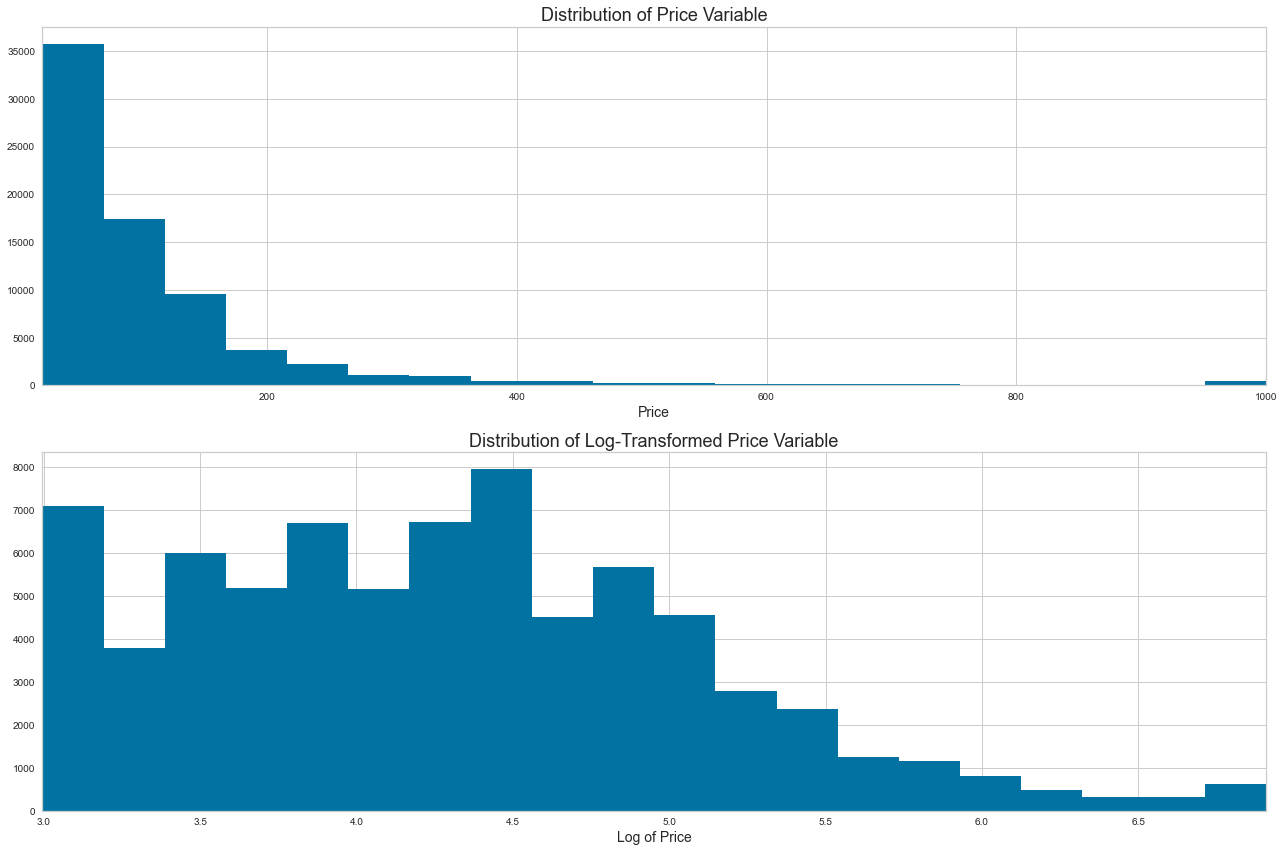

In [99]:
fig,ax = plt.subplots(2,1,figsize=(18,12))

ax[0].hist(x=y, bins=20)
ax[1].hist(x=np.log(y), bins=20)

ax[0].set_title('Distribution of Price Variable', fontsize=18)
ax[1].set_title('Distribution of Log-Transformed Price Variable', fontsize=18)

ax[0].set_xlabel('Price', fontsize=14)
ax[1].set_xlabel('Log of Price', fontsize=14)

ax[0].margins(x=0)
ax[1].margins(x=0)

plt.tight_layout()

plt.show()

## Linear regression with regularisation


The first models I'm going to try are linear regression models with regularisation (Ridge, Lasso and Elastic Net). As linear regression is much less computationally expensive than ensemble models, which I'll be trying later on, these are always a good place to start when using regression to solve a problem.

Given that my dataset has a lot of variables, some of which have correlation between one another, it wouldn't make sense to use a linear regression model without regularisation.

For each model, I'm going to instantiate them in their EstimatorCV formats. This will allow my to plug in a range of different hyper-parameter values to search for the model with the most optimal performance (i.e. the highest r2 score). Each cross-validation will be conducted over 5 folds

Finally, I'll print out the optimal hyper-parameters for each model along with the training, test and mean cross-validation scores.

In [143]:
# setting up a dataframe to score the scores of my models

r2_scores_df = pd.DataFrame({'Training_Score': [],'Test_Score': [],'CV_Mean_Score': []},)

In [144]:
# instantiating the log-transformed target variables

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

### Ridge

In [145]:
model = RidgeCV(np.logspace(-5, 5, 100),cv=5)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('model', model)])

pipe.fit(X_train,y_train_log)

best_alpha = model.alpha_
training_score = pipe.score(X_train, y_train_log)
cv_mean_score = model.best_score_
test_score = pipe.score(X_test, y_test_log)


model_r = Ridge(alpha=best_alpha)

pipe_r = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('model', model_r)])

pipe_r.fit(X_train, y_train_log)

cv_scores = cross_val_score(pipe_r, X_train, y_train_log, cv=5)

# get the best alpha
print('Best alpha:', best_alpha)
# evaluate on the training set
print('Training score:', training_score)
# cross-validated scores
print('CV Scores:', cv_scores)
# mean cross-validated scores
print('CV Mean Score:', cv_mean_score)
# evaluate on the test set
print("Test Score:", test_score)

Best alpha: 187.3817422860383
Training score: 0.459969947632639
CV Scores: [0.46068457 0.44819545 0.46761967 0.45615255 0.45796615]
CV Mean Score: 0.4581238986101712
Test Score: 0.4658102215420592


In [146]:
# adding scores to dataframe

r2_scores_df.loc['Ridge'] = [training_score, test_score, cv_mean_score]

### Lasso

In [147]:
model = LassoCV(alphas=np.logspace(-5, 5, 100),cv=5)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('model', model)])

pipe.fit(X_train,y_train_log)

best_alpha = model.alpha_
training_score = pipe.score(X_train, y_train_log)
test_score = pipe.score(X_test, y_test_log)

model_l = Lasso(alpha=best_alpha)

pipe_l = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('model', model_l)])

pipe_l.fit(X_train, y_train_log)

cv_scores = cross_val_score(pipe_l, X_train, y_train_log, cv=5)
cv_mean_score = cv_scores.mean()

# get the best alpha
print('Best alpha:', best_alpha)
# evaluate on the training set
print('Training score:', training_score)
# cross-validated scores
print('CV Scores:', cv_scores)
# mean cross-validated scores
print('CV Mean Score:', cv_mean_score)
# evaluate on the test set
print("Test Score:", test_score)

Best alpha: 0.00025950242113997375
Training score: 0.4599487010765053
CV Scores: [0.46071373 0.44828263 0.46759563 0.45619771 0.45791069]
CV Mean Score: 0.4581400776544947
Test Score: 0.46578279850321136


In [148]:
# adding scores to dataframe

r2_scores_df.loc['Lasso'] = [training_score, test_score, cv_mean_score]

### Elastic Net 

In [149]:
model= ElasticNetCV(l1_ratio=[0.00001, 0.001, 0.01, 0.1, 
                               0.5, 0.7, 0.9, 0.95, 0.99, 1],
                     alphas=np.logspace(-5, 5, 100),
                     cv=5, max_iter=100000)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('model', model)])

pipe.fit(X_train,y_train_log)

best_alpha = model.alpha_
best_l1_ratio = model.l1_ratio_
training_score = pipe.score(X_train, y_train_log)
test_score = pipe.score(X_test, y_test_log)

model_en = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=100000)

pipe_en = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('model', model_en)])

pipe_en.fit(X_train, y_train_log)

cv_scores = cross_val_score(pipe_en, X_train, y_train_log, cv=5)
cv_mean_score = cv_scores.mean()

# get the best alpha
print('Best alpha:', best_alpha)
# get the best l1-ratio
print('Best l1-ratio:', best_l1_ratio)
# evaluate on the training set
print('Training score:', training_score)
# cross-validated scores
print('CV Scores:', cv_scores)
# mean cross-validated scores
print('CV Mean Score:', cv_mean_score)
# evaluate on the test set
print("Test Score:", test_score)

Best alpha: 0.00032745491628777284
Best l1-ratio: 0.9
Training score: 0.45994331502700314
CV Scores: [0.46071587 0.44828698 0.46759315 0.45619671 0.45790941]
CV Mean Score: 0.45814042439302644
Test Score: 0.465775387258752


In [150]:
# adding scores to dataframe

r2_scores_df.loc['Elastic Net'] = [training_score, test_score, cv_mean_score]

### Model Comparison

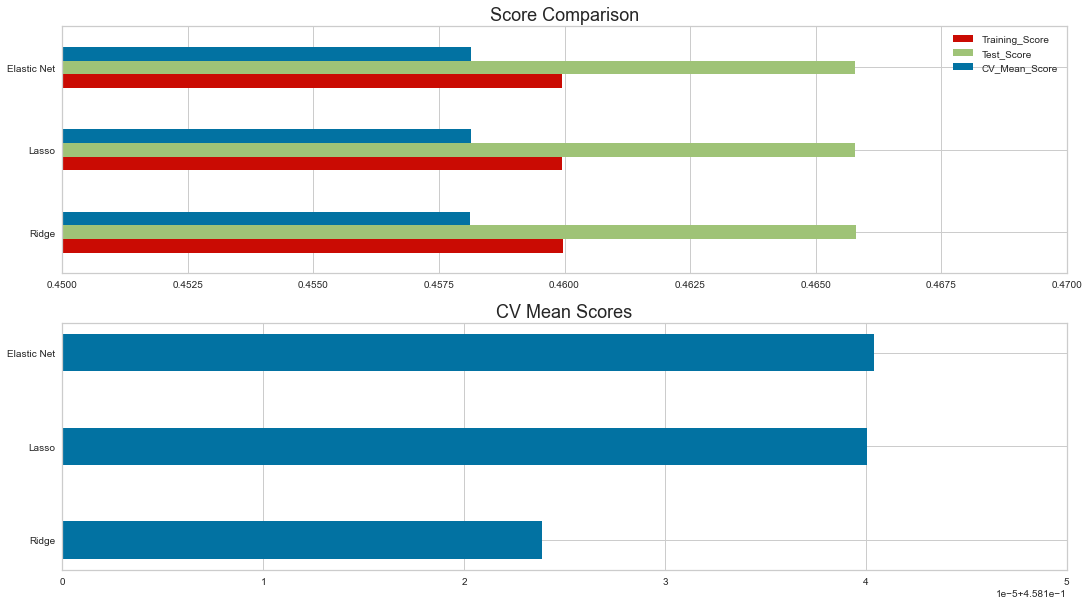

In [231]:
fig,ax = plt.subplots(2,1,figsize=(18,10))

r2_scores_df.plot.barh(ax=ax[0],color=['r','g','b'])
ax[0].set_xlim([0.45,0.47])
ax[0].set_title('Score Comparison', fontsize=18)

ax[1].barh(y=r2_scores_df.index,width=r2_scores_df.CV_Mean_Score, height=0.4)
ax[1].set_xlim([0.4581,0.458150])
ax[1].set_title('CV Mean Scores', fontsize=18)

plt.show()

### Comparing True Values with Predicted Values

In [235]:
predictions_train_en = pipe_en.predict(X_train)
predictions_test_en = pipe_en.predict(X_test)

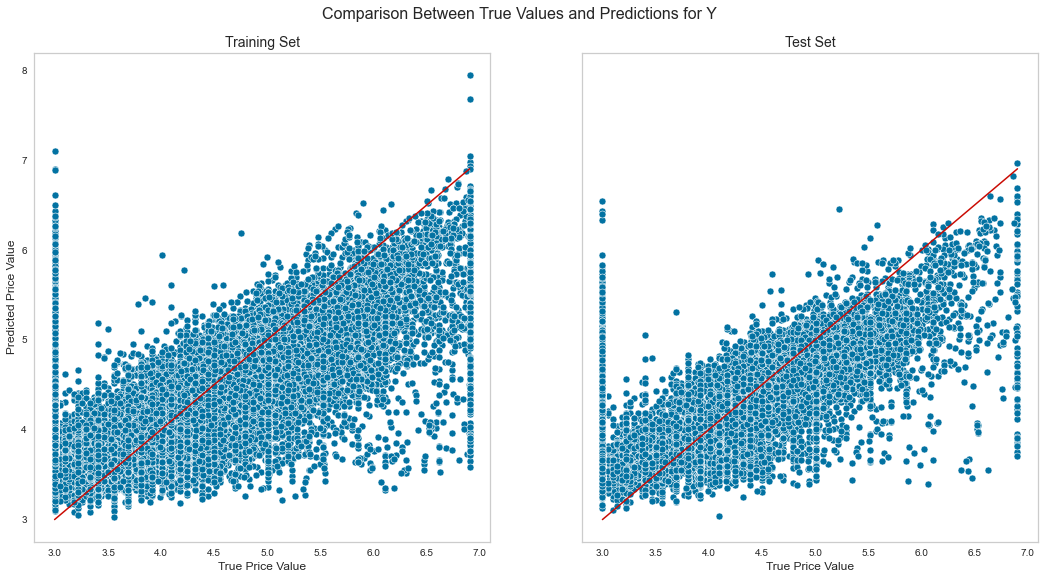

In [245]:
# instantiating the predicted values

fig, ax = plt.subplots(1,2,figsize=(18,9), sharey=True)


sns.scatterplot(x = y_train_log, y = predictions_train_en, ax=ax[0])
ax[0].set_title('Training Set', fontsize=14)

sns.scatterplot(x = y_test_log, y = predictions_test_en, ax=ax[1],legend=False)
ax[1].set_title('Test Set', fontsize=14)

ax[0].grid()
ax[0].set_xlabel('True Price Value', fontsize=12)
ax[0].set_ylabel('Predicted Price Value', fontsize=12)

ax[1].grid()
ax[1].set_xlabel('True Price Value', fontsize=12)
ax[1].set_ylabel('Predicted Price Value', fontsize=12)


ax[0].plot([y_train_log.min(), y_train_log.max()], [y_train_log.min(), y_train_log.max()], lw=1.5, c='r')
ax[1].plot([y_test_log.min(), y_test_log.max()], [y_test_log.min(), y_test_log.max()], lw=1.5, c='r')

plt.suptitle('Comparison Between True Values and Predictions for Y', fontsize=16, y=0.95)
plt.show()

### Decision Tree Regressor

In [15]:
decision_tree = DecisionTreeRegressor()

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('decision_tree', decision_tree)])

In [16]:
params = {'decision_tree__max_depth': range(3,11),
         'decision_tree__min_samples_split': [2,10,30,50],
         'decision_tree__min_samples_leaf': [1,5,10,30,50],
         'decision_tree__max_features': ['auto', 0.8, 0.5, 'sqrt']}

In [17]:
gs_decision_tree = GridSearchCV(pipe, params, cv=5, n_jobs=-2, verbose=2)

In [18]:
gs_decision_tree.fit(X_train,y_train)

print("Training Score: {}".format(gs_decision_tree.score(X_train,y_train)))
print("Test Score: {}".format(gs_decision_tree.score(X_test,y_test)))
print("CV Mean Score: {}".format(gs_decision_tree.best_score_))
print("Best Model Parameters: {}".format(gs_decision_tree.best_params_))

Fitting 5 folds for each of 640 candidates, totalling 3200 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-2)]: Done 351 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-2)]: Done 634 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-2)]: Done 999 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-2)]: Done 1444 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-2)]: Done 1971 tasks      | elapsed:  3.0min
/Users/jamesradford/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-2)]: Done 2578 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-2)]: Done 3200 out of 3200 | elapsed:  5.3min finished


Training Score: 0.6150027637205997
Test Score: 0.5203279899867976
CV Mean Score: 0.5083160479382611
Best Model Parameters: {'decision_tree__max_depth': 10, 'decision_tree__max_features': 0.8, 'decision_tree__min_samples_leaf': 5, 'decision_tree__min_samples_split': 30}


# INSERT A VIZ SHOWING HOW THE DECISION TREE WORKS

### Random Forest Regressor

In [71]:
random_forest = RandomForestRegressor(n_jobs=-2,random_state=1, verbose=1)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('random_forest', random_forest)])

params = {'random_forest__n_estimators': [100, 150],
         'random_forest__max_depth': [None, 10, 50],
         'random_forest__min_samples_leaf': [1,5,30],
         'random_forest__max_features': ['auto', 0.8],
         'random_forest__max_samples': [None, 0.8],
         'random_forest__ccp_alpha': [0, 0.005, 0.01]}

gs_random_forest = GridSearchCV(pipe, params, cv=5, n_jobs=-2, verbose=2)

In [74]:
gs_random_forest.fit(X_train,y_train)

print("Training Score: {}".format(gs_random_forest.score(X_train,y_train)))
print("Test Score: {}".format(gs_random_forest.score(X_test,y_test)))
print("CV Mean Score: {}".format(gs_random_forest.best_score_))
print("Best Model Parameters: {}".format(gs_random_forest.best_params_))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-2)]: Done 351 tasks      | elapsed: 44.5min
[Parallel(n_jobs=-2)]: Done 634 tasks      | elapsed: 105.2min
[Parallel(n_jobs=-2)]: Done 999 tasks      | elapsed: 191.9min
[Parallel(n_jobs=-2)]: Done 1080 out of 1080 | elapsed: 213.4min finished
[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-2)]: Done 150 out of 150 | elapsed:  1.5min finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.1s


Training Score: 0.9459556960470796
Test Score: 0.6291665344653148
CV Mean Score: 0.6107639031987422
Best Model Parameters: {'random_forest__ccp_alpha': 0.005, 'random_forest__max_depth': None, 'random_forest__max_features': 0.8, 'random_forest__max_samples': None, 'random_forest__min_samples_leaf': 1, 'random_forest__n_estimators': 150}


[Parallel(n_jobs=7)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 150 out of 150 | elapsed:    0.1s finished


In [79]:
# saving the pipeline and best estimator

# joblib.dump(pipe,'../data/jlib_files/pipe_random_forest_1')
# joblib.dump(gs_random_forest.best_estimator_,'../data/jlib_files/model_random_forest_1')

['../data/jlib_files/model_random_forest_1']

### Gradient Boosting Regressor

In [92]:
gradient_boosting = GradientBoostingRegressor(random_state=1)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('gradient_boosting', gradient_boosting)])

params = {'gradient_boosting__n_estimators': [100,150],
         'gradient_boosting__subsample': [0.8, 1],
         'gradient_boosting__min_samples_split': [2,15,30],
         'gradient_boosting__min_samples_leaf': [1, 5],
         'gradient_boosting__max_depth': [3, 5, 10],
         'gradient_boosting__max_features': ['auto', 'sqrt'],
         'gradient_boosting__ccp_alpha': [0, 0.005, 0.01]
         }

gs_grad_boost = GridSearchCV(pipe, params, cv=5, n_jobs=-2, verbose=1)

In [93]:
gs_grad_boost.fit(X_train,y_train)

print("Training Score: {}".format(gs_grad_boost.score(X_train,y_train)))
print("Test Score: {}".format(gs_grad_boost.score(X_test,y_test)))
print("CV Mean Score: {}".format(gs_grad_boost.best_score_))
print("Best Model Parameters: {}".format(gs_grad_boost.best_params_))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
/Users/jamesradford/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed: 68.0min
[Parallel(n_jobs=-2)]: Done 1236 tasks      | elapsed: 101.4min
[Parallel(n_jobs=-2)]: Done 1786 tasks      | elapsed: 149.3min
[Parallel(n_jobs=-2)]: Done 2160 out of 2160 | elapsed: 184.6min finished


Training Score: 0.893968414648733
Test Score: 0.6262948839118985
CV Mean Score: 0.6134737528844415
Best Model Parameters: {'gradient_boosting__ccp_alpha': 0, 'gradient_boosting__max_depth': 10, 'gradient_boosting__max_features': 'sqrt', 'gradient_boosting__min_samples_leaf': 1, 'gradient_boosting__min_samples_split': 2, 'gradient_boosting__n_estimators': 150, 'gradient_boosting__subsample': 1}


In [94]:
# saving the pipeline and best estimator

# joblib.dump(pipe,'../data/jlib_files/pipe_gradient_boosting_1')
# joblib.dump(gs_grad_boost.best_estimator_,'../data/jlib_files/model_gradient_boosting_1')

['../data/jlib_files/model_gradient_boosting_1']

### Bagging Regressor

In [26]:
bagging_regressor = BaggingRegressor(n_jobs=-2)

ridge = Ridge(alpha=148.4968)
decision_tree = DecisionTreeRegressor(max_depth = 10, max_features = 0.8, min_samples_leaf = 5,
                                      min_samples_split = 30)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('br', bagging_regressor)])

params = {'br__base_estimator': [ridge, decision_tree],
         'br__n_estimators': [20, 60, 120],
         'br__max_samples': [0.5, 0.8, 1.0, 1.2],
         'br__max_features': [0.5, 0.8, 1.0, 1.2],
         'br__bootstrap': [True, False]}

gs_bag_regressor = GridSearchCV(pipe, params, cv=5, n_jobs=-2, verbose=1)

In [27]:
gs_bag_regressor.fit(X_train,y_train)

print("Training Score: {}".format(gs_bag_regressor.score(X_train,y_train)))
print("Test Score: {}".format(gs_bag_regressor.score(X_test,y_test)))
print("CV Mean Score: {}".format(gs_bag_regressor.best_score_))
print("Best Model Parameters: {}".format(gs_bag_regressor.best_params_))

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-2)]: Done 960 out of 960 | elapsed: 31.7min finished


Training Score: 0.6625696822099179
Test Score: 0.5939912759681434
CV Mean Score: 0.5784979996168834
Best Model Parameters: {'br__base_estimator': DecisionTreeRegressor(max_depth=10, max_features=0.8, min_samples_leaf=5,
                      min_samples_split=30), 'br__bootstrap': False, 'br__max_features': 0.8, 'br__max_samples': 1.0, 'br__n_estimators': 60}


# Analyse the results of the gradient boosting regressor

In [7]:
grad_boost = joblib.load("../data/jlib_files/models/model_gradient_boosting_1")
grad_boost.fit(X_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('dummy',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['host_response_time',
                                                   'host_response_rate',
                                                   'host_acceptance_rate',
                                                   'neighbourhood', 'room_type',
                                                   'property_type_basic'])])),
                ('scaler', StandardScaler()),
                ('gradient_boosting',
                 GradientBoostingRegressor(ccp_alpha=0, max_depth=10,
                                           max_features='sqrt',
                                           n_estimators=150, random_state=1

In [8]:
# combining train and test sets and adding the predictions

predictions_train = grad_boost.predict(X_train)
predictions_test = grad_boost.predict(X_test)

train_vis = X_train.copy()
test_vis = X_test.copy()

train_vis['price_true'] = y_train
test_vis['price_true'] = y_test

train_vis['price_pred'] = predictions_train
test_vis['price_pred'] = predictions_test

train_vis['residuals'] = train_vis.price_true - train_vis.price_pred
test_vis['residuals'] = test_vis.price_true - test_vis.price_pred

train_vis['residuals_abs'] = abs(train_vis.residuals)
test_vis['residuals_abs'] = abs(test_vis.residuals)

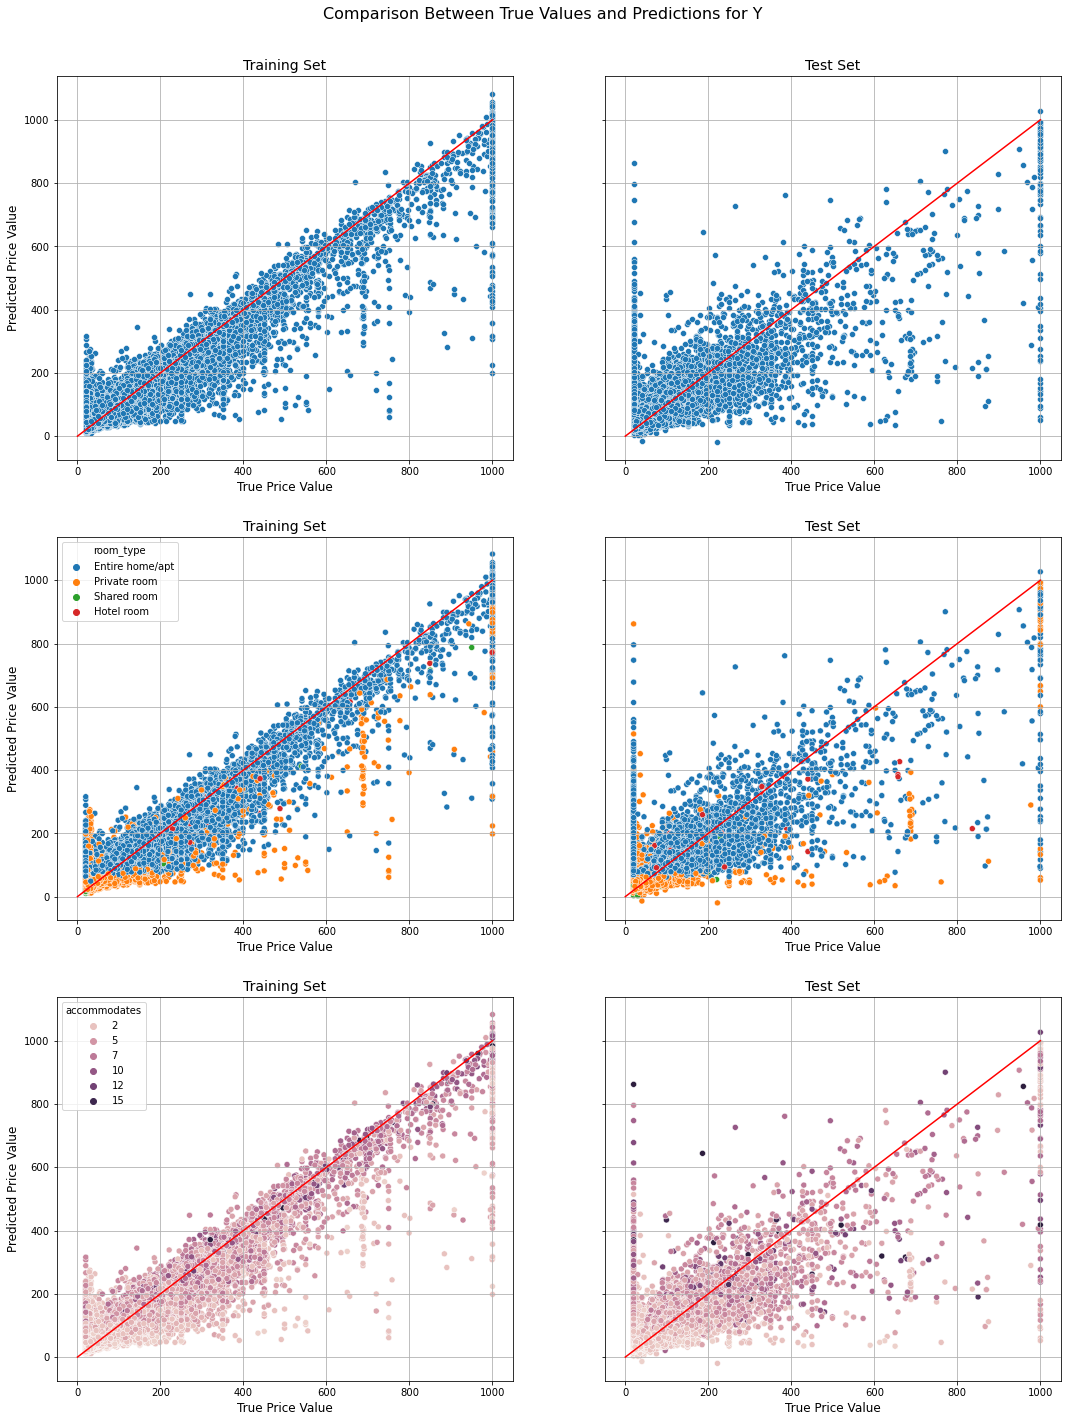

In [17]:
fig, ax = plt.subplots(3,2,figsize=(18,24), sharey=True)

for ax_tuple, variable in zip(enumerate(ax.flatten()),[None, None, 'room_type','room_type', 'accommodates', 'accommodates']):
    
    if ax_tuple[0]%2==0:
        sns.scatterplot(x = 'price_true', y = 'price_pred', hue = variable, data = train_vis, ax=ax_tuple[1])
        ax_tuple[1].set_title('Training Set', fontsize=14)
    else:    
        sns.scatterplot(x = 'price_true', y = 'price_pred', hue = variable, data = test_vis, ax=ax_tuple[1],
                       legend=False)
        ax_tuple[1].set_title('Test Set', fontsize=14)

    ax_tuple[1].grid()
    ax_tuple[1].set_xlabel('True Price Value', fontsize=12)
    ax_tuple[1].set_ylabel('Predicted Price Value', fontsize=12)

    ax_tuple[1].plot([0, df.price.max()], [0, df.price.max()], lw=1.5, c='r')

plt.suptitle('Comparison Between True Values and Predictions for Y', fontsize=16, y=0.92)
plt.show()

Why has the model predicted minus values in the test set?

In [10]:
test_df = X_test.copy()
test_df['true_price'] = y_test
test_df['predicted_price'] = predictions_test

In [11]:
test_df[test_df.predicted_price < 0]

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood,room_type,accommodates,bathrooms,...,mean_monthly_rent,serviced_property,description_provided,host_about_provided,name_length,description_length,neighborhood_overview_length,host_about_length,true_price,predicted_price
3896,within an hour,Above or equal to 75%,Above or equal to 75%,0,1,1,Croydon,Private room,1,1.0,...,1371.0,0,1,1,5,163,75,182,40.0,-13.863915
37796,within an hour,Above or equal to 75%,Below 75% or not displayed,1,1,1,Hackney,Private room,2,1.0,...,1437.0,0,1,0,7,97,100,0,222.0,-19.824656


In [12]:
p_room_residuals = test_vis[(test_vis.room_type=='Private room')&(test_vis.residuals_abs >50)]

In [13]:
feature_names = grad_boost.named_steps['col_trans'].get_feature_names()
feature_importances = grad_boost.named_steps['gradient_boosting'].feature_importances_

feature_df = pd.DataFrame({'feature_importance': feature_importances},index=feature_names)

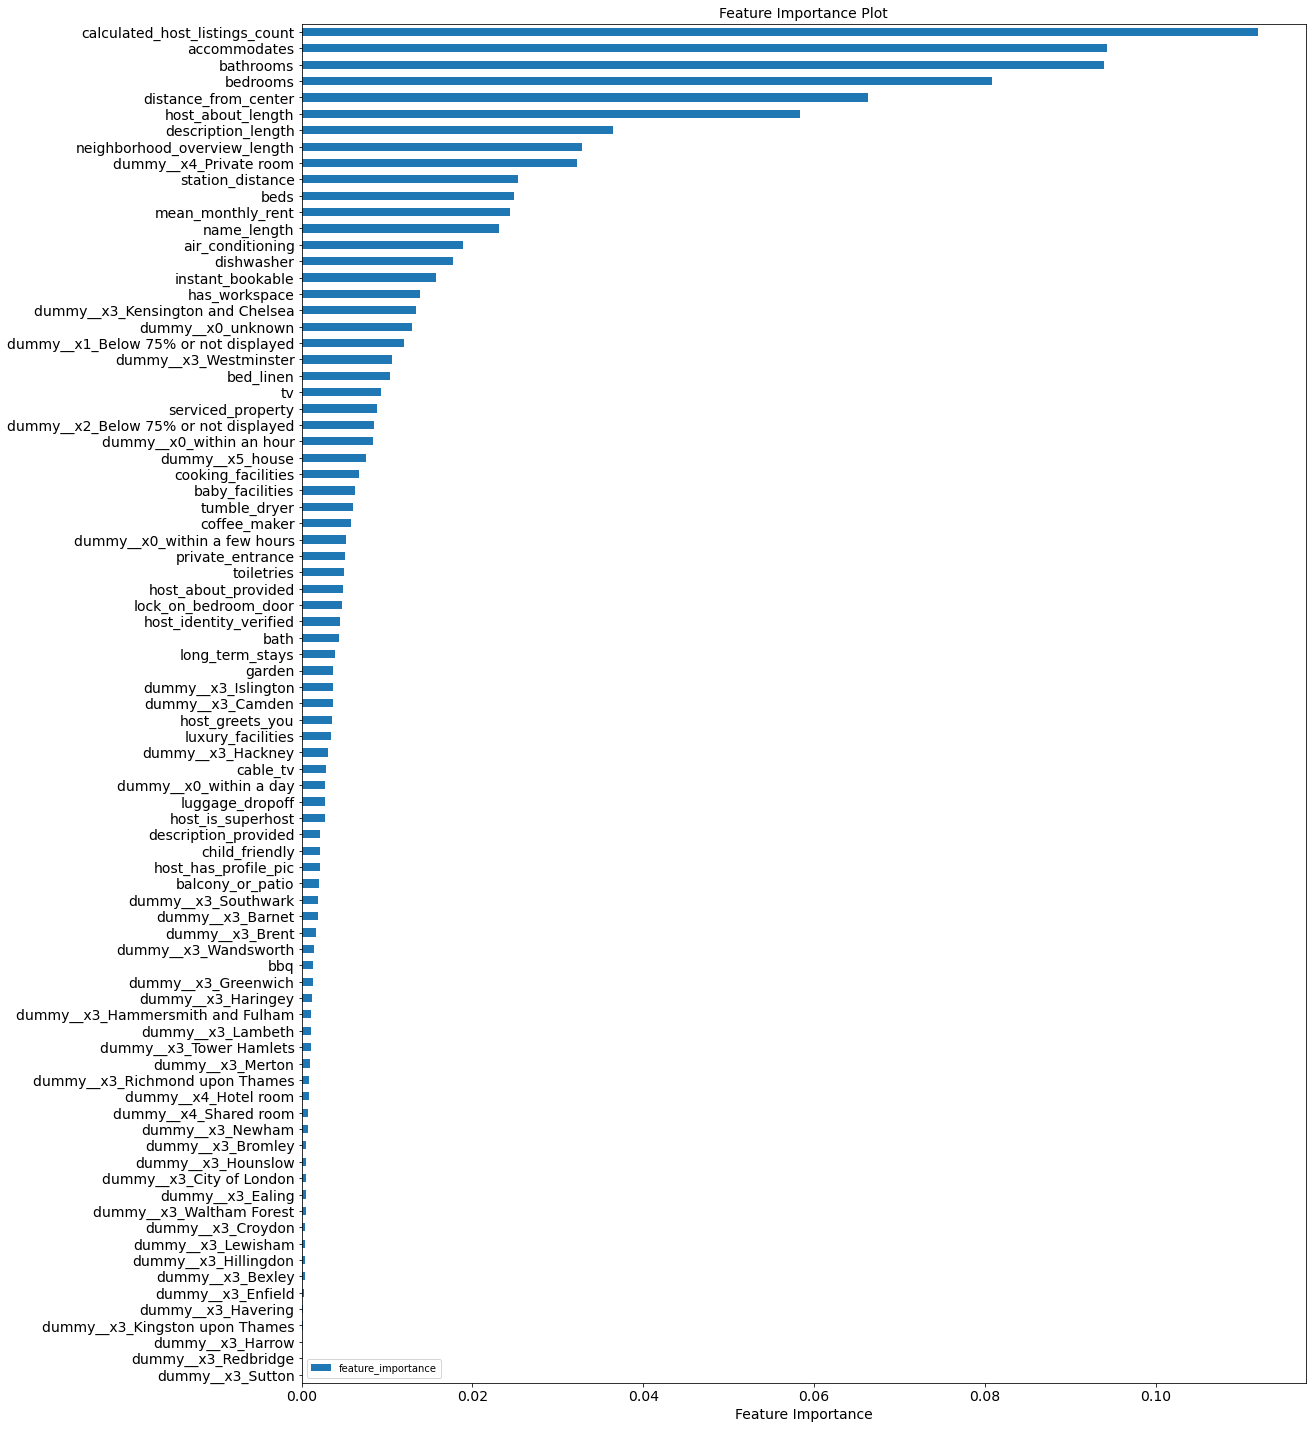

In [14]:
fig,ax = plt.subplots(figsize=(18,25))

feature_df.sort_values('feature_importance').plot.barh(ax=ax,fontsize=14)

ax.set_title('Feature Importance Plot', fontsize=(14))
ax.set_xlabel('Feature Importance', fontsize=(14))

plt.show()

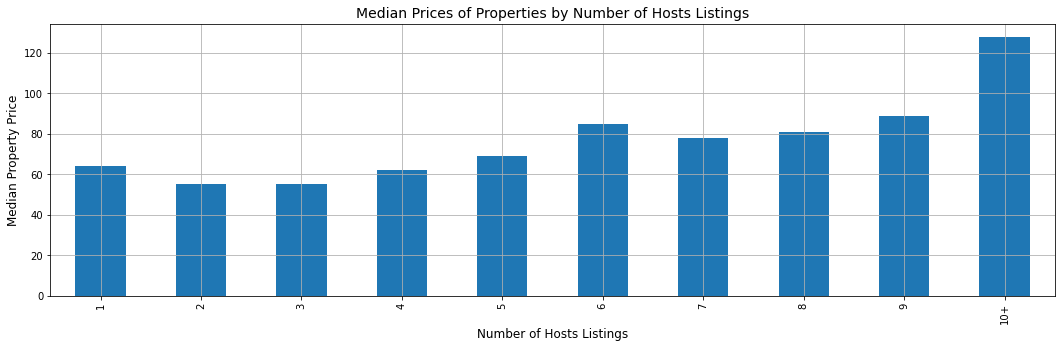

In [15]:
df_vis['host_listings_obj'] = df_vis.calculated_host_listings_count.apply(lambda x: "10+" if x>= 10 else x)

fig,ax=plt.subplots(figsize=(18,5))

df_vis.groupby('host_listings_obj').median()['price'].plot.bar(ax=ax, grid=True)

ax.set_title('Median Prices of Properties by Number of Hosts Listings', fontsize=14)
ax.set_xlabel('Number of Hosts Listings', fontsize=12)
ax.set_ylabel('Median Property Price', fontsize=12)

plt.show()

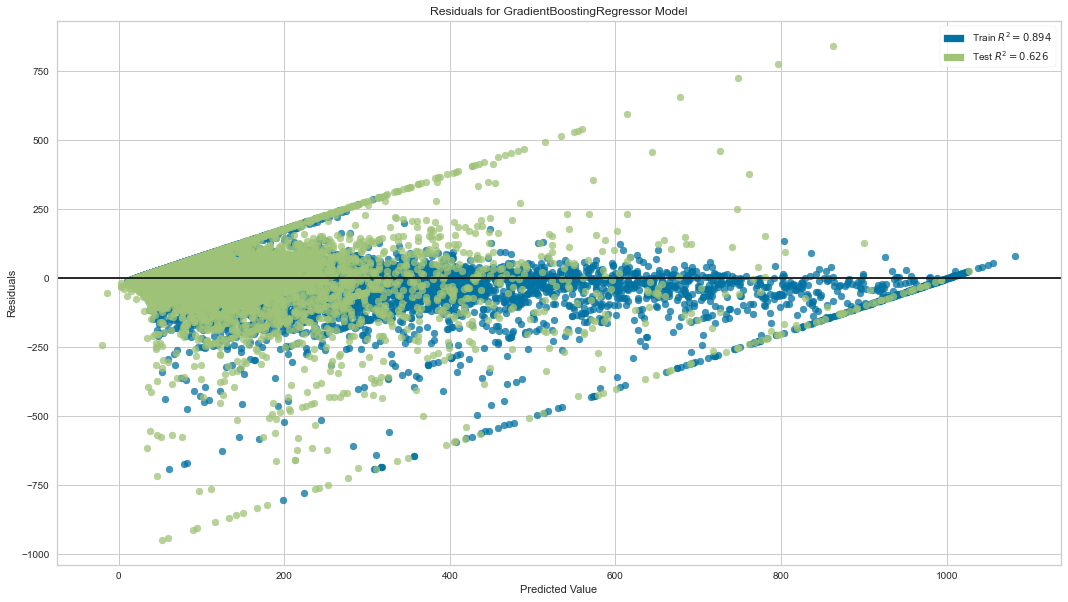

In [32]:
fig,ax=plt.subplots(figsize=(18,10))

visualizer = ResidualsPlot(grad_boost,ax=ax,hist=False)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

plt.show()